# Transfer Learning with Pytorch

In this excercise, you will implement a 2-class classification neural network, using transfer learning from a pre-trained resnet18 network. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve (but not identical). The pre-trained network could have been trained on a different dataset and sometimes also on a different task. The important thing is that it would be a related task and a realted dataset. This way, we can leverage previous learneinng to solve the new problem (instead of training the model from scratch). The ResNet18 model was pre-trained on the [ImageNet](http://image-net.org/index) dataset (a large dataset consisting of 1.4M images and 1000 classes). 

Transfer learning can be used in two ways:
1. Feature extractor: Here we remove top layers, freeze the weights of all remaining layers, add a new fully connected layers on top of the pretrained model. Then. we train only these new layers to solve the new task.
2. Fine tuning: Here we unfreezing the entire model (or part of it), add a new fully connected layers on top of the pre-trained model (as before) and re-train the entire model on the new data with a very low learning rate. We can use either end-to-end re-training, or re-train only part of the network.

### CIFAR-10 Dataset:

In this assignment, you will need to perform transfer learning using the ResNet18 network in order to classify and discern between images of cats and dogs in a different dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 



# Part 1- Feature Extractor

In this part of the exercise, you need to classify images of 'Cat' and 'Dog' by using transfer learning with the feature extractor approach and a pre-trained ResNet18 network.

The pre-trained model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers. You will need to extract the image representation that should be fed into a classifier. For the classifier, please use a single fully-connected layer. 


In order to make things efficient, start by using the ResNet18 network in order to extract image represetnations for the images in CIFAR-10 dataset. Please make sure to this only once (please do not extract the image representations each time it is needed in the training phase)! You can store the resulting image representations as feature vectors and train the classifier using these vectors. At test time, you can merge both network in order to achive a single end-to-end classifier.  
Note: This is different from what you saw in the recitation (dl_r4_cnns).

At the test time, you can merge the feature extraction netowork with the new prediction head, in order to recive a "full solution".


**Let's first import all the packages that you will need during this part of assignment:**

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset


import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import time

import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc


from torch import optim
from tqdm import tqdm

import torch.nn.functional as F

#imported for pytorch
# from IPython.display import display
# import torch.nn.functional as F


The ResNet18 network requires images of at least 200x200 pixels. However, the CIFAR-10 dataset consists of small images of 32x32 pixels. Hence, you will need to reshape the images before we use them into the ResNet18 network.
Additionally, you will need to match the normalization used while training the ResNet18: each color channel should be normalized separately. The channel means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

In [ ]:
# Specify transforms using torchvision.transforms as transforms library

### START CODE HERE ###
train_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
infer_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)



**Use the transforms library from  torchvision and definethese transformations:**

In [ ]:
### START CODE HERE ###

def print_current_time(output = ''):
    import datetime
    import pytz
    current_time = datetime.datetime.now(pytz.timezone('Israel'))
    if output == '':
        print("The current time is: ")
    else:
        print(output)

    print(current_time)
    print()





class TrainArgs:

    batch_size = 10


args = TrainArgs()


from torch.utils.data import DataLoader

train_dataset = datasets.CIFAR10("cifar", transform=train_transform, download=True)

test_dataset = datasets.CIFAR10("cifar", transform=infer_transform, download=True)











Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


#### Load CIFAR10 dataset and transform dataset from torchvision:

**Note that the CIFAR10 data set includes 10 labels. Please extract from the entire dataset, only the images with 'Cat' or 'Dog' labels.
In order to make the training process faster, you will need to trim the train set to 800 training images of each label (800 dogs and 800 cats). The test set should be trimmed to 250 images of cats and 250 images of dogs.**

In [ ]:
# Note: In order to separating the data/label you can apply "classes"/"targets" methods on CIFAR10 data sets
### START CODE HERE ###

def get_cat_dog_indices_and_labels(dataset):


  labels = dataset.targets
  index = 0
  cat_dogs_data_indices_and_labels = []

  for label in labels:
    if (label == 5 or label == 3) : 
      cat_dogs_data_indices_and_labels.append([index,label])
  
    index = index + 1

  return(cat_dogs_data_indices_and_labels)


cat_dogs_data_indices_and_labels = []
cat_dogs_data_indices_and_labels =  get_cat_dog_indices_and_labels(train_dataset)


   



In [ ]:
# creating data that includes just cats and dogs and later on, load it to the dataset

def create_dataloader(dataset, cat_dogs_data_indices_and_labels, start_index, end_index ):

  from random import shuffle

  cat_data_indices= []

  for  i in range(len(cat_dogs_data_indices_and_labels)):
    if cat_dogs_data_indices_and_labels[i][1] ==  3 :
      cat_data_indices.append(cat_dogs_data_indices_and_labels[i][0])

  dataloader_cat_data_indices =  []
  dataloader_cat_data_indices=  cat_data_indices [start_index : end_index]


      
  dog_data_indices= []

  for  i in range(len(cat_dogs_data_indices_and_labels)):
    if cat_dogs_data_indices_and_labels[i][1] ==  5 :
      dog_data_indices.append(cat_dogs_data_indices_and_labels[i][0])

  dataloader_dog_data_indices =  []
  dataloader_dog_data_indices =  dog_data_indices [start_index : end_index]



  cat_and_dogs_dataloader_data_indices  = []
  cat_and_dogs_dataloader_data_indices = dataloader_cat_data_indices  +  dataloader_dog_data_indices 
  shuffle(cat_and_dogs_dataloader_data_indices )


  cat_dog_dataset = Subset(dataset, cat_and_dogs_dataloader_data_indices )

  cat_dog_dataloader = DataLoader(cat_dog_dataset, batch_size=args.batch_size)


  # keeping just the labels of cat and fog ant transofrm their value to 0 and 1
  i = 0
  new_targets = []
  for target in  cat_dog_dataloader.dataset.dataset.targets:
    if target ==3:
      new_targets.append(0)
    elif target ==5:
      new_targets.append(1)
    else:
      new_targets.append(999)
    i = i+1  

  
  cat_dog_dataloader.dataset.dataset.targets = new_targets.copy()

  return (cat_dog_dataloader)


cat_dog_train_dataloader = create_dataloader(train_dataset ,cat_dogs_data_indices_and_labels, 0,800 )

cat_dog_test_dataloader = create_dataloader(test_dataset ,cat_dogs_data_indices_and_labels, 800, 1050)


del train_dataset , test_dataset, cat_dogs_data_indices_and_labels




         

**Download the ResNet18 Network from torchvision.models (as seen in the tutorial):**

In [ ]:
### START CODE HERE ###
resnet_fe_18 = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


#### Now, use the pre-trained Resnet18 to extract feautres from the CIFAR10 dataset and feed your classifier with these feature vectors. To do that, you need to cut the head of the pre-trained ResNet18 model, then feed the model with the CIFAR10 data sets (train and test).  The resulting image representations should be "flattened" and used as feature vectors:

In [ ]:
### START CODE HERE ###
def discconet_head_resnet(resnet_fe):
  print(f"The modules are: {resnet_fe._modules.keys()}")
  num_rep_channels = resnet_fe.fc.in_features
  resnet_fe.fc = nn.Identity()

  # return(resnet_fe) we marked this because we have recieved a RAM error

  # Freezing the resnet:
  for param in resnet_fe.parameters():
      param.requires_grad = False
  # Creating a new net based on the resnet
  my_resnet = nn.Sequential(resnet_fe ,nn.Flatten())

  return(my_resnet)


resnet_18_without_head = discconet_head_resnet(resnet_fe_18)




The modules are: odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])


# Logistic Regression with scikit-learn library:

#### Here, you need to use a logistic regession model from scikit-learn and train it with the data you prepared above. You need to calculate and report the accuracy and AUC for the train and test sets and explain your results.

In [ ]:
def  create_logistic_regression(X_train, y_train ): 
  from sklearn.linear_model import LogisticRegression 
  from sklearn.model_selection import RandomizedSearchCV
  from pprint import pprint
  from sklearn.model_selection import KFold

  Log_Reg=LogisticRegression(random_state= 42) 
  kf = KFold(n_splits = 10, shuffle= True, random_state= 42)
  solver = ['newton-cg', 'lbfgs', 'sag' ,'saga' ,'liblinear' ] 
  #multi_class = ['auto', 'ovr']  
 # penalty = ['none']
  fit_intercept =  [True, False]
  C = np.linspace(1e-3, 1e3, 10)  
  # Create the random grid
  random_grid = {'solver': solver,
                #'penalty' :penalty,
                #'multi_class': multi_class
                'fit_intercept' :   fit_intercept,
                 #'max_iter': 1000
                 'C': C 

                 }

  pprint(random_grid) 
  # search across 100 different combinations, and use all available cores 
  Log_Reg_random  = RandomizedSearchCV(estimator = Log_Reg , 
                                param_distributions = random_grid, 
                                n_iter = 20, cv = kf, verbose=2, 
                                random_state=42, n_jobs = -1)

  print_current_time("\n \n start to fit sklearn LR")
  Log_Reg_random.fit(X_train, y_train)
  print_current_time(" \n \n finish to fit sklearn LR")
  print("best hyperparameters for Logistic Regression are:")
  pprint(Log_Reg_random.best_params_)
  print("") 
  Log_Reg_best_random = Log_Reg_random.best_estimator_ 
  
  return  Log_Reg_best_random



In [ ]:
def use_res_and_convert_numpy(resnet, dataloader):

  X_res_batch = []
  X_tensor_dataset = []
  X_numpy_dataset = []   

  y_numpy_dataset = []
  y_batches = []
  y_tensor_dataset = []

  for x, y in tqdm(dataloader):
    pred = resnet(x)
    X_res_batch.append(pred)
    y_batches.append(y)

  for batch in  X_res_batch:
    for X_res in batch:
        X_tensor_dataset.append(X_res)

  
  for x_tensor in X_tensor_dataset:
      x_numpy =  x_tensor.detach().numpy()
      X_numpy_dataset.append(x_numpy )

  for y_batch in  y_batches:
    for y_tensor in  y_batch:

      y_tensor_dataset.append(y_tensor)
        
      y_numpy =    y_tensor.detach().numpy()
      y_numpy_dataset.append( y_numpy )

  return(X_numpy_dataset, X_tensor_dataset ,y_numpy_dataset, y_tensor_dataset)    



print_current_time("start to activate resnet18 net on data ")

X_train, X_tensor_train, y_train, y_tensor_train =   use_res_and_convert_numpy(resnet_18_without_head , cat_dog_train_dataloader)

X_test, X_tensor_test, y_test, y_tensor_test =   use_res_and_convert_numpy(resnet_18_without_head , cat_dog_test_dataloader)

print_current_time("finish to activate resnet18 net on data ")

  0%|          | 0/160 [00:00<?, ?it/s]

start to activate resnet18 net on data 
2021-02-25 21:55:57.136019+02:00



100%|██████████| 50/50 [00:44<00:00,  1.13it/s]

finish to activate resnet18 net on data 
2021-02-25 21:59:04.157999+02:00



In [ ]:
import pandas as pd

def print_classification_report(y_test,model_predictions):
    from sklearn.metrics import classification_report
    report = classification_report(y_test, model_predictions, output_dict=True,target_names=["0", "1"])
    print("Precision - recall results:")
    display(pd.DataFrame(report).transpose().round(2))

def print_confusion_matrix(y_test, model_predicitions):
  from sklearn.metrics import confusion_matrix
  CM_gbc=confusion_matrix(y_test, model_predicitions)
  print("Confusion Matrix:")
  print(pd.DataFrame(CM_gbc, index = ["Actual 0","Actual 1"],
                                       columns = ["Predicted 0","Predicted 1"] ))
  
def print_auc (y , y_predict):
   
  auc_value= roc_auc_score(y , y_predict)
  print("AUC value: " , auc_value )    

  
def print_results_metrics (y, y_predict, text= ""):

  if text != "":
      print (text)

  print_classification_report(y, y_predict)

  print_confusion_matrix(y,y_predict)

  print_auc (y, y_predict)

  print("\n \n \n \n")











In [ ]:
logistic_regression_res_18= create_logistic_regression(X_train, y_train)


y_train_pred = logistic_regression_res_18.predict(X_train)
print_results_metrics (y_train, y_train_pred, "Metrics for train prediction: \n")


y_test_pred = logistic_regression_res_18.predict(X_test)
print_results_metrics (y_test, y_test_pred, "Metrics for test prediction: \n")

del y_test_pred, y_train_pred, logistic_regression_res_18

{'C': array([1.00000e-03, 1.11112e+02, 2.22223e+02, 3.33334e+02, 4.44445e+02,
       5.55556e+02, 6.66667e+02, 7.77778e+02, 8.88889e+02, 1.00000e+03]),
 'fit_intercept': [True, False],
 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']}

 
 start to fit sklearn LR
2021-02-25 21:59:04.208064+02:00

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.3min


 
 
 finish to fit sklearn LR
2021-02-25 22:02:41.336650+02:00

best hyperparameters for Logistic Regression are:
{'C': 0.001, 'fit_intercept': True, 'solver': 'newton-cg'}

Metrics for train prediction: 

Precision - recall results:


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.6min finished


,precision,recall,f1-score,support
0,0.77,0.80,0.79,800.00
1,0.80,0.76,0.78,800.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.78,0.78,0.78,1600.00
weighted avg,0.78,0.78,0.78,1600.00


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          644          156
Actual 1          191          609
AUC value:  0.783125

 
 
 

Metrics for test prediction: 

Precision - recall results:


,precision,recall,f1-score,support
0,0.80,0.82,0.81,250.00
1,0.81,0.80,0.81,250.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.81,0.81,0.81,500.00
weighted avg,0.81,0.81,0.81,500.00


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          204           46
Actual 1           50          200
AUC value:  0.808

 
 
 



We used the LogisticRegression library, and we tried to optimize our result using K-fold with K=10. In addition, we used a random search in order to find the best hyper-parameters for the model. The best Hyper-parameters that were found are: C = 0.001, fit_intercept = True and solver = newton-cg.  




# Logistic Regression with pytorch:

#### Next, you need to use a logistic regession using pythourch as follows:


1. Explain the choice of architecture in the head of the neural network.
2. Plot training loss per epoch.
3. Plot AUC per epoch for train and validation sets.
4. Explain your results and findings.
5. Does adding one or two hidden layers affect the generalization capabilities of the model?

1) Explanation about the architecture: we didn't want to use too many hidden layers in order to avoid overfitting, so we used 3 hidden layers.We used Adam optimizer since we have learned in class that it is known as the best optimizer and most commonly used optimizer as it combines Momentum, RMSprop and bias correction.We added a dropout layer in order to avoid overfitting.We used weight decay for regularization.We chose the best lr among the learning rates that we have tried and saw that lr = 0.0000009 gave the best result.We stopped the training after we saw that there is overfitting so the number of epochs is 17000.

4) Explanation about the results and findings: we have got accuracy and f1-score of 0.77 which is better than the SKLRN logistic regression. We can see that the model showing training loss higher than test loss up until around 13800 epochs, we assume that the model is not yet stable at that point and as expected the model start to show better results on training data compering to the test data around 15000 epochs, after that we can see that the model for the test is slightly improving so we stopped the learning in 17000 when we can see that there is no much learning for the test data comparing to the training data (in order to avoid overfitting)5.

 5) We have tried the net with no hidden layers and we saw that the results are much worse compared to the net with 3 hidden layers - we have got accuracy equal to 0.5, which is no better than a flip of a coin, so we understand that without the hidden layers the net doesn't have the opportunity to learn any pattern or correlations so it doesn't give good results, and we can see that the loss function doesn't change so there is no learning or any improvement with no hidden layers.



#### Define the model:

In [ ]:
def infer(net, x, y, criterion):
  net.eval()

  with torch.no_grad():
      pred = net(x)
      loss = criterion(pred, y.reshape(-1,1)).item()
  return loss




def calculate_test_auc(net, x, y):
    net.eval()
    with torch.no_grad():
        pred = net(x)
    return calculate_auc(pred, y)





def calculate_auc(y, y_pred =[], X_test= [], train=True, net= None):

    if not train:
        net.eval()
        with torch.no_grad():
          y_pred = net(X_test)


    y_numpy = y.detach().numpy()
    y_pred_numpy = y_pred.round().detach().numpy()

    fpr, tpr, thresholds = roc_curve(y_numpy , y_pred_numpy)

    return auc(fpr, tpr)


def training_loop(net, X_train, y_train, X_test, y_test, epochs, criterion_func, optimizer):

    criterion = criterion_func
    train_loss, test_loss, train_auc, test_auc = [None] * epochs, [None] * epochs, [None] * epochs, [None] * epochs

    X_train = torch.stack(X_train)
    y_train = torch.stack(y_train)
    y_train = y_train.type(torch.FloatTensor)


    X_test = torch.stack(X_test)
    y_test_numpy = y_test.copy()
    y_test = torch.stack(y_test)
    y_test = y_test.type(torch.FloatTensor)

    print_current_time("Strat to fit pytorch LR")

    for epoch in range(epochs):

        net.train()
        optimizer.zero_grad()

        y_pred_train = net(X_train)

        loss = criterion(y_pred_train, y_train.reshape(-1,1))
        loss.backward()
        optimizer.step()

        train_loss[epoch] = loss.item()
        test_loss[epoch] = infer(net, X_test, y_test, criterion)


        train_auc[epoch] = calculate_auc(y= y_train, y_pred= y_pred_train)
        test_auc[epoch] =  calculate_auc(y = y_test , X_test = X_test, train = False, net = net)



        if epoch%1000 == 0:

            print("Epoch numbers: ", epoch)
            print("The training loss is: ", train_loss[epoch])
            print("The test loss is: ",  test_loss[epoch], "\n")



    y_test_predicted = net(X_test).round().detach().numpy().reshape(-1, )
    print_classification_report(y_test, y_test_predicted)

    print_current_time("finish to fit pytorch LR")


    return train_loss, test_loss, train_auc, test_auc, net


class LR_pytorch(torch.nn.Module):

   def __init__(self):
      super( LR_pytorch, self).__init__()
      self.fc1 = torch.nn.Linear(512,256)
      self.fc2 =  torch.nn.Linear(256,128)
      self.fc3 =  torch.nn.Linear(128,64)
      self.fc4 =  torch.nn.Linear(64,5)
      self.fc5 =  torch.nn.Linear(5,1)

      self.dropout = nn.Dropout(0.5)

   def forward (self,x):

     x = F.relu(self.fc1(x))
     x = self.dropout(x)
     x = self.fc2(x)
     x = F.relu(self.fc3(x))
     x = self.fc4(x)
     x = self.dropout(x)
     y_pred = torch.sigmoid (self.fc5(x))
     return y_pred  

lr_pytroch_net =  LR_pytorch()

class LR_with_zero_hidden_layers(torch.nn.Module):

   def __init__(self):
      super(LR_with_zero_hidden_layers, self).__init__()
      self.fc1 = torch.nn.Linear(512,1)



   def forward (self,x):

     y_pred = torch.sigmoid (self.fc1(x))
     return y_pred


lr_no_hidden_layers_net =  LR_with_zero_hidden_layers()

#### Training and validation:

In [ ]:
num_epochs = 17000
lr = 0.0000009
criterion_func =torch.nn.BCELoss(size_average= True)

optimizer = optim.Adam(lr_pytroch_net.parameters(), lr=lr, weight_decay=5e-4)

"""#### Training and validation:"""

train_loss_values , test_loss_values, train_auc_values, test_auc_values, fc_lr_pytorch = training_loop(lr_pytroch_net,  X_tensor_train, y_tensor_train, X_tensor_test, y_tensor_test, num_epochs, criterion_func, optimizer)

print("\n \n \n \n")
print("check result with network with zero hidden layers")
a,b,c,d,e,= training_loop(lr_no_hidden_layers_net,  X_tensor_train, y_tensor_train, X_tensor_test, y_tensor_test, 10000, criterion_func, optimizer)
del a,b,c,d,e

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Strat to fit pytorch LR
2021-02-25 22:02:41.689673+02:00

Epoch numbers:  0
The training loss is:  0.7046921253204346
The test loss is:  0.7055411338806152 

Epoch numbers:  1000
The training loss is:  0.692742109298706
The test loss is:  0.6892339587211609 

Epoch numbers:  2000
The training loss is:  0.6795401573181152
The test loss is:  0.6739507913589478 

Epoch numbers:  3000
The training loss is:  0.6574341058731079
The test loss is:  0.6508037447929382 

Epoch numbers:  4000
The training loss is:  0.6317489743232727
The test loss is:  0.6198984980583191 

Epoch numbers:  5000
The training loss is:  0.6010552644729614
The test loss is:  0.5835204720497131 

Epoch numbers:  6000
The training loss is:  0.571763813495636
The test loss is:  0.5497623085975647 

Epoch numbers:  7000
The training loss is:  0.5445260405540466
The test loss is:  0.5210780501365662 

Epoch numbers:  8000
The training loss is:  0.5150537490844727
The test loss is:  0.49845921993255615 

Epoch numbers:  900

,precision,recall,f1-score,support
0,0.82,0.79,0.80,250.00
1,0.80,0.82,0.81,250.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.81,0.81,0.81,500.00
weighted avg,0.81,0.81,0.81,500.00


finish to fit pytorch LR
2021-02-25 22:14:10.805809+02:00


 
 
 

check result with network with zero hidden layers
Strat to fit pytorch LR
2021-02-25 22:14:10.826300+02:00

Epoch numbers:  0
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoch numbers:  1000
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoch numbers:  2000
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoch numbers:  3000
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoch numbers:  4000
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoch numbers:  5000
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoch numbers:  6000
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoch numbers:  7000
The training loss is:  0.6825308799743652
The test loss is:  0.6658985614776611 

Epoc

,precision,recall,f1-score,support
0,0.58,0.68,0.63,250.0
1,0.62,0.51,0.56,250.0
accuracy,0.60,0.60,0.60,0.6
macro avg,0.60,0.60,0.59,500.0
weighted avg,0.60,0.60,0.59,500.0


finish to fit pytorch LR
2021-02-25 22:15:05.900759+02:00



#### Visualizing the plots:

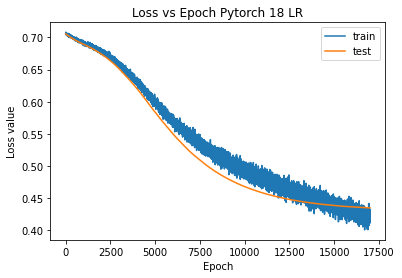

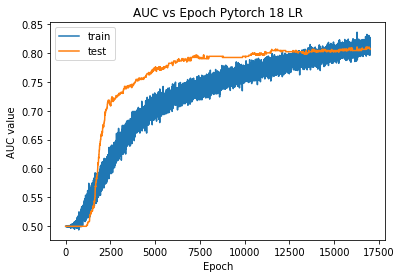

In [ ]:
### START CODE HERE ###

def plot_loss_by_epoch (num_epochs, loss_train_list, loss_test_list, model_name) :
# loss vs epoch
  epoch = [epoch for epoch in range(num_epochs)]
  cost_train =     loss_train_list
  cost_test =      loss_test_list
  plt.plot(epoch, cost_train, label = 'train')
  plt.plot(epoch, cost_test,  label = 'test' )
  plt.title('Loss vs Epoch '+ model_name)
  plt.xlabel('Epoch')
  plt.ylabel('Loss value')
  plt.legend()
  plt.show()

def plot_auc_by_epoch(num_epochs, auc_values_train, auc_values_test, model_name ):
# AUC vs epoch
  epoch = [epoch for epoch in range(num_epochs)]
  auc_train =  auc_values_train
  auc_test  =  auc_values_test
  plt.plot(epoch, auc_values_train, label= "train")
  plt.plot(epoch, auc_values_test, label= "test")
  plt.title('AUC vs Epoch '+ model_name)
  plt.xlabel('Epoch')
  plt.ylabel('AUC value')
  plt.legend()
  plt.show()



plot_loss_by_epoch (num_epochs, train_loss_values, test_loss_values, "Pytorch 18 LR")

plot_auc_by_epoch(num_epochs, train_auc_values, test_auc_values, "Pytorch 18 LR" )



**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [ ]:
### START CODE HERE ###
import copy

resnet_18_with_lr_head =  copy.deepcopy(resnet_18_without_head)
resnet_18_with_lr_head.fc =   fc_lr_pytorch

print ("connected FC to headless resnet 18")
del resnet_18_without_head

connected FC to headless resnet 18


# Comparing  ResNet18 with ResNet34:

#### Download the ResNet34 Network from torchvision.models. Then, repeat the steps described above in order to compare between these ResNet18 and ResNet43. Explain your findings and results!

In [ ]:
### START CODE HERE ###
resnet_fe_34 = models.resnet34(pretrained=True)

resnet_34_without_head = discconet_head_resnet(resnet_fe_34)

print_current_time("start to activate resnet34 net on data ")

X_train_34, X_tensor_train_34, y_train_34, y_tensor_train_34 =   use_res_and_convert_numpy(resnet_34_without_head , cat_dog_train_dataloader)

X_test_34, X_tensor_test_34, y_test_34, y_tensor_test_34 =   use_res_and_convert_numpy(resnet_34_without_head , cat_dog_test_dataloader)

print_current_time("finish to activate resnet34 net on data ")


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0/160 [00:00<?, ?it/s]

The modules are: odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])
start to activate resnet34 net on data 
2021-02-25 22:15:18.214596+02:00



100%|██████████| 50/50 [01:20<00:00,  1.61s/it]

finish to activate resnet34 net on data 
2021-02-25 22:20:55.531467+02:00



# Logistic Regression with scikit-learn library:

In [ ]:
logistic_regression_res_34= create_logistic_regression(X_train_34, y_train_34)

y_test_pred = []
y_test_pred_34 = logistic_regression_res_34.predict(X_test_34)

{'C': array([1.00000e-03, 1.11112e+02, 2.22223e+02, 3.33334e+02, 4.44445e+02,
       5.55556e+02, 6.66667e+02, 7.77778e+02, 8.88889e+02, 1.00000e+03]),
 'fit_intercept': [True, False],
 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']}

 
 start to fit sklearn LR
2021-02-25 22:20:55.543965+02:00

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min


 
 
 finish to fit sklearn LR
2021-02-25 22:24:04.758862+02:00

best hyperparameters for Logistic Regression are:
{'C': 0.001, 'fit_intercept': True, 'solver': 'newton-cg'}



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


In [ ]:
## START CODE HERE ###
print_results_metrics (y_test_34, y_test_pred_34)

Precision - recall results:


,precision,recall,f1-score,support
0,0.81,0.81,0.81,250.00
1,0.81,0.81,0.81,250.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.81,0.81,0.81,500.00
weighted avg,0.81,0.81,0.81,500.00


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          203           47
Actual 1           47          203
AUC value:  0.812

 
 
 



# Logistic Regression with pytorch for ResNet34:

#### Define the model:



In [ ]:
class LR_34_pytorch(torch.nn.Module):

   def __init__(self):

      super(LR_34_pytorch, self).__init__()
      self.fc1 = torch.nn.Linear(512,256)
      self.fc2 =  torch.nn.Linear(256,128)
      self.fc3 =  torch.nn.Linear(128,64)
      self.fc4 =  torch.nn.Linear(64,5)
      self.fc5 =  torch.nn.Linear(5,1)

      self.dropout = nn.Dropout(0.5)

   def forward (self,x):

     x = F.relu(self.fc1(x))
     x = self.dropout(x)
     x = self.fc2(x)
     x = F.relu(self.fc3(x))
     x = self.fc4(x)
     x = self.dropout(x)
     y_pred = torch.sigmoid (self.fc5(x))
     return y_pred




lr_pytroch_res34_net =  LR_34_pytorch()


#### Training and validation:

In [ ]:
### START CODE HERE ###
num_epochs = 17000
lr = 0.0000009
criterion_func =torch.nn.BCELoss(size_average= True)

optimizer = optim.Adam(lr_pytroch_res34_net.parameters(), lr=lr, weight_decay=5e-4)



"""#### Training and validation:"""
train_loss_34_values , test_loss_34_values, train_auc_34_values, test_auc_34_values, fc_34_lr_pytorch = training_loop(lr_pytroch_res34_net,  X_tensor_train_34, y_tensor_train_34, X_tensor_test_34, y_tensor_test_34, num_epochs, criterion_func, optimizer)



Strat to fit pytorch LR
2021-02-25 22:24:04.904494+02:00

Epoch numbers:  0
The training loss is:  0.6930444836616516
The test loss is:  0.6916544437408447 



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch numbers:  1000
The training loss is:  0.6828233599662781
The test loss is:  0.6793859004974365 

Epoch numbers:  2000
The training loss is:  0.6628764271736145
The test loss is:  0.6579371094703674 

Epoch numbers:  3000
The training loss is:  0.6320884823799133
The test loss is:  0.6227211952209473 

Epoch numbers:  4000
The training loss is:  0.5985225439071655
The test loss is:  0.5816329717636108 

Epoch numbers:  5000
The training loss is:  0.5597503781318665
The test loss is:  0.539601743221283 

Epoch numbers:  6000
The training loss is:  0.5379102230072021
The test loss is:  0.5032786130905151 

Epoch numbers:  7000
The training loss is:  0.5011340379714966
The test loss is:  0.474607914686203 

Epoch numbers:  8000
The training loss is:  0.484981507062912
The test loss is:  0.4533654451370239 

Epoch numbers:  9000
The training loss is:  0.45766913890838623
The test loss is:  0.4382152259349823 

Epoch numbers:  10000
The training loss is:  0.45423823595046997
The test l

,precision,recall,f1-score,support
0,0.84,0.82,0.83,250.00
1,0.82,0.84,0.83,250.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.83,0.83,0.83,500.00
weighted avg,0.83,0.83,0.83,500.00


finish to fit pytorch LR
2021-02-25 22:35:26.536927+02:00



#### Visualizing the plots:

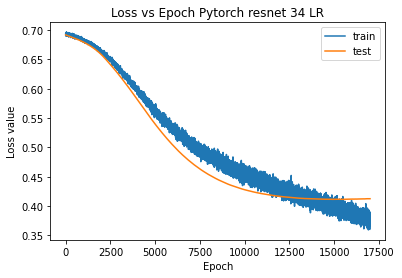

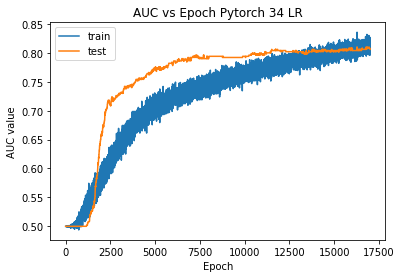

In [ ]:
### START CODE HERE ###
plot_loss_by_epoch (num_epochs, train_loss_34_values, test_loss_34_values, "Pytorch resnet 34 LR")

plot_auc_by_epoch(num_epochs, train_auc_values, test_auc_values, "Pytorch 34 LR" )


**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [ ]:
### START CODE HERE ###

resnet_34_with_lr_head = nn.Sequential(resnet_34_without_head, fc_34_lr_pytorch)
print ("connected FC to headless resnet 34")

del lr_pytroch_res34_net, train_loss_34_values , test_loss_34_values, train_auc_34_values, test_auc_34_values, fc_34_lr_pytorch ,  resnet_34_with_lr_head

connected FC to headless resnet 34


# Part 2- Fine-tuning

In the feature extraction experiment above you were training the classifier on the top of the pre-trained model. 
In this paert, you need to train (or "fine-tune") the original pre-trained Resnet18 model (or part of them) in an attempts to improve your results. You can determine the number of convolution layers you intend to re-train in order to avoid overfitting and hopefully achive better generalization. Note that the fine-tuning should only be attempted after you have trained the top-level classifier with a pre-trained model.

1. Plot Loss and Accuracy v.s Epoch for train and validation sets:

#### Define the model (use the merged feature extractor with the PyTorch logistic regression classifier)

In [ ]:
### START CODE HERE ###

def freeze_resnet(resnet,freeze_bn1, freeze_conv1, freeze_layer1, freeze_layer2, freeze_layer3, freeze_layer4, freeze_fc):

    resnet_architecture = resnet._modules["0"]

    bn1 =    resnet_architecture.bn1
    conv1 =  resnet_architecture.conv1
    layer1 = resnet_architecture.layer1
    layer2 = resnet_architecture.layer2
    layer3 = resnet_architecture.layer3
    layer4 = resnet_architecture.layer4
    fc = resnet_18_with_lr_head.fc

    for par in resnet.parameters():
        par.requires_grad =  True

    for par in fc.parameters():
        par.requires_grad = True

    if freeze_bn1:
        print("freezing weights in bn1")
        bn1_par = bn1.parameters()
        for par in bn1_par:
            par.requires_grad = False

    if freeze_conv1:
        print("freezing weights in conv1")
        conv1_par = conv1.parameters()
        for par in conv1_par:
            par.requires_grad = False


    if freeze_layer1:
        print ("freezing weights in layer1")
        layer1_par = layer1.parameters()
        for par in layer1_par:
            par.requires_grad = False

    if freeze_layer2:
        print("freezing weights in layer2")
        layer2_par = layer2.parameters()
        for par in layer2_par:
            par.requires_grad = False

    if freeze_layer3:
        print("freezing weights in layer3")
        layer3_par = layer3.parameters()
        for par in layer3_par:
            par.requires_grad = False

    if freeze_layer4:
        print("freezing weights in layer4")
        layer4_par = layer4.parameters()
        for par in layer4_par:
            par.requires_grad = False

    if freeze_fc:
        print("freezing weights in FC")
        for par in fc.parameters():
            par.requires_grad = False




    return (resnet)




#
#
def calculate_accuracy(y_pred, y):

    y_numpy= y.detach().numpy()

    y_pred_numpy = y_pred.round().detach().numpy().reshape(-1,)

    correct_amount = np.sum(y_numpy == y_pred_numpy)
    accuracy_value = correct_amount /  len(y_numpy)

    return accuracy_value




resnet_18_with_lr_head = freeze_resnet(resnet_18_with_lr_head, freeze_bn1= False, freeze_conv1= False, freeze_layer1= False , freeze_layer2= False, freeze_layer3= False, freeze_layer4= False, freeze_fc= False)


# print all grads status
# for par in resnet_18_with_lr_head.parameters():
#     print(par.requires_grad)
#
# for par in resnet_18_with_lr_head.fc.parameters():
#     print(par.requires_grad)


criterion_func =torch.nn.BCELoss(size_average= True)
lr = 0.0000009
num_epochs = 35
optimizer = optim.Adam(resnet_18_with_lr_head.parameters(), lr=lr, weight_decay=5e-4)












/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


#### Training and validation:

In [ ]:
### START CODE HERE ###

def get_test_metrics(net, test_dataloader, criterion):

    epoch_total_test_loss = 0
    epoch_total_test_accuracy = 0
    test_dataloader_length = len(test_dataloader)

    net.eval()

    for x_test, y_test in test_dataloader:

        y_test = y_test.type(torch.FloatTensor)

        with torch.no_grad():
            y_test_pred = net(x_test)

            #calculates loss
            loss = criterion(y_test_pred, y_test.reshape(-1,1)).item()
            epoch_total_test_loss += loss

            # calculates accuracy
            epoch_total_test_accuracy +=  calculate_accuracy(y_test_pred, y_test)

    epoch_test_loss = 0
    epoch_test_loss =    epoch_total_test_loss/ test_dataloader_length

    epoch_test_accuracy = 0
    epoch_test_accuracy =    epoch_total_test_accuracy / test_dataloader_length


    return(epoch_test_loss, epoch_test_accuracy)


def training_loop_dataloader(net, train_dataloader, test_dataloader, epochs, criterion_func, optimizer):

    criterion = criterion_func
    train_loss,test_loss, train_accuracy, test_accuracy = [None] * epochs, [None] * epochs, [None] * epochs, [None] * epochs

    for epoch in range(epochs):

        epoch_total_train_loss = 0
        epoch_total_train_accuracy = 0

        print_current_time("final tuning train epoch: "+ str(epoch))
        print()

        net.train()

        for x, y in train_dataloader:

            y = y.type(torch.FloatTensor)

            optimizer.zero_grad()

            y_pred_train = net(x)

            loss = criterion(y_pred_train, y.reshape(-1,1))
            loss.backward()
            epoch_total_train_loss += loss

            epoch_total_train_accuracy += calculate_accuracy(y_pred_train, y)

            optimizer.step()

         #calculates metrics for  train data

        train_loss[epoch] = epoch_total_train_loss.item() / len(train_dataloader)

        train_accuracy[epoch] = epoch_total_train_accuracy / len(train_dataloader)

          #calculates metrics for test data

        test_loss[epoch], test_accuracy[epoch] = get_test_metrics(net, test_dataloader, criterion)

        print("Epoch number: ", epoch)

        print("The training loss is: ", train_loss[epoch])

        print("The test loss is: ", test_loss[epoch], "\n")
        print("accuracy test score: ", test_accuracy[epoch], "\n")

    return train_loss, test_loss, train_accuracy, test_accuracy, net


train_loss_values_final_tuning , test_loss_values_final_tuning , train_accuracy_values_final_tuning , test_accuracy_values_final_tuning , fc_lr_pytorch = training_loop_dataloader(resnet_18_with_lr_head, cat_dog_train_dataloader, cat_dog_test_dataloader, num_epochs , criterion_func, optimizer)


final tuning train epoch: 0
2021-02-25 22:35:27.198001+02:00


Epoch number:  0
The training loss is:  0.45448932647705076
The test loss is:  0.4255352732539177 

accuracy test score:  0.8039999999999999 

final tuning train epoch: 1
2021-02-25 22:43:10.735001+02:00


Epoch number:  1
The training loss is:  0.459397554397583
The test loss is:  0.42379657238721846 

accuracy test score:  0.8019999999999997 

final tuning train epoch: 2
2021-02-25 22:50:53.750511+02:00


Epoch number:  2
The training loss is:  0.44432053565979
The test loss is:  0.41313787817955017 

accuracy test score:  0.8059999999999998 

final tuning train epoch: 3
2021-02-25 22:58:37.013000+02:00


Epoch number:  3
The training loss is:  0.41504764556884766
The test loss is:  0.4077932733297348 

accuracy test score:  0.8039999999999999 

final tuning train epoch: 4
2021-02-25 23:06:21.342935+02:00


Epoch number:  4
The training loss is:  0.4303277015686035
The test loss is:  0.4027138003706932 

accuracy test sco

KeyboardInterrupt: ignored

#### Visualizing the plots:

In [ ]:
### START CODE HERE ###

def plot_accuracy_by_epoch (num_epochs, accuracy_train_list, accuracy_test_list, model_name) :
# accuracy vs epoch
  epoch = [epoch for epoch in range(num_epochs)]
  cost_train =     accuracy_train_list
  cost_test =      accuracy_test_list
  plt.plot(epoch, cost_train, label = 'train')
  plt.plot(epoch, cost_test,  label = 'test' )
  plt.title('accuracy vs Epoch '+ model_name)
  plt.xlabel('Epoch')
  plt.ylabel('accuracy value')
  plt.legend()
  plt.show()





plot_loss_by_epoch (num_epochs, train_loss_values_final_tuning, test_loss_values_final_tuning, "Final tuning net")
plot_accuracy_by_epoch(num_epochs, train_accuracy_values_final_tuning,  test_accuracy_values_final_tuning, "Final tuning net")

2. Compare your results between the two approaches. Is there any improvement? Explain your findings...


Type your answer here:

During our training, we froze each time other combinations of Resnet layers.  The current net gave us the best results. We can see that training the pre-trained Resnet18 gave us better results. We have excepted this because the pre-trained net wasn't trained on our data, and fitting it on our data improve the net predictions.